Configuration & Path Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Dynamic Path Setup
current_dir = os.getcwd()
project_root = current_dir

# Climb up until we find 'src'
while not os.path.exists(os.path.join(project_root, 'src')):
    parent = os.path.dirname(project_root)
    if parent == project_root:
        raise FileNotFoundError("Could not find 'src'. Are you in the project folder?")
    project_root = parent

if project_root not in sys.path:
    sys.path.append(project_root)

DATA_PATH = os.path.join(project_root, 'data')
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")

# 2. Import Custom Modules

from src.data_loader import ClinicalTrialLoader
from src.preprocessing import get_pipeline


Project Root: /home/delaunan/code/delaunan/clintrialpredict
Data Path:    /home/delaunan/code/delaunan/clintrialpredict/data


 Smart Data Loading (Auto-Generation)

In [3]:
CSV_PATH = os.path.join(DATA_PATH, 'project_data.csv')
FORCE_REGENERATE = False  # Set to True if you changed code in data_loader.py

if os.path.exists(CSV_PATH) and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")
    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> Loading existing dataset from: /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (67363, 36)


In [4]:
df.columns

Index(['nct_id', 'start_date_type', 'start_date', 'study_type',
       'overall_status', 'phase', 'number_of_arms', 'why_stopped', 'target',
       'start_year', 'phase_ordinal', 'covid_exposure', 'includes_us',
       'is_international', 'allocation', 'intervention_model',
       'primary_purpose', 'masking', 'num_primary_endpoints', 'lead_sponsor',
       'agency_class', 'sponsor_clean', 'sponsor_tier', 'gender',
       'healthy_volunteers', 'adult', 'child', 'older_adult',
       'criteria_len_log', 'best_pathology', 'therapeutic_area',
       'therapeutic_subgroup_name', 'competition_broad', 'competition_niche',
       'txt_tags', 'txt_criteria'],
      dtype='object')

Temporal Split (Time Travel) <br>
Why: We sort by date to ensure strict separation of Past (Train) and Future (Test).

In [5]:
# ----------------------------------------------------------------------------------
# TEMPORAL SPLIT & STATISTICS REPORT
# ----------------------------------------------------------------------------------

# 1. Sort by Date to ensure we predict the future from the past
df = df.sort_values('start_year').reset_index(drop=True)

# 2. Define Split Point (e.g., 80% Train, 20% Test)
split_idx = int(len(df) * 0.80)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 3. Define Features & Target
target_col = 'target'
drop_cols = [target_col, 'overall_status', 'nct_id']

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target_col]

# ----------------------------------------------------------------------------------
# PRINT STATISTICS
# ----------------------------------------------------------------------------------
def print_stats(name, dataset, y):
    n_total = len(dataset)
    n_good = len(dataset[y == 0]) # 0 = Completed
    n_bad = len(dataset[y == 1])  # 1 = Terminated/Withdrawn

    pct_good = (n_good / n_total) * 100
    pct_bad = (n_bad / n_total) * 100

    min_year = dataset['start_year'].min()
    max_year = dataset['start_year'].max()

    print(f"--- {name} SET ---")
    print(f"Time Period:   {int(min_year)} to {int(max_year)}")
    print(f"Total Trials:  {n_total}")
    print(f"Good (0):      {n_good} ({pct_good:.1f}%)")
    print(f"Bad (1):       {n_bad} ({pct_bad:.1f}%)")
    print("")

print("="*40)
print("DATASET SPLIT STATISTICS")
print("="*40)

# Overall
print_stats("OVERALL", df, df[target_col])

# Training
print_stats("TRAINING (Past)", train_df, y_train)

# Testing
print_stats("TESTING (Future)", test_df, y_test)

print("="*40)
print(f"Split Ratio: {len(train_df)/len(df):.0%} Train / {len(test_df)/len(df):.0%} Test")

DATASET SPLIT STATISTICS
--- OVERALL SET ---
Time Period:   2000 to 2015
Total Trials:  67363
Good (0):      56414 (83.7%)
Bad (1):       10949 (16.3%)

--- TRAINING (Past) SET ---
Time Period:   2000 to 2013
Total Trials:  53890
Good (0):      45441 (84.3%)
Bad (1):       8449 (15.7%)

--- TESTING (Future) SET ---
Time Period:   2013 to 2015
Total Trials:  13473
Good (0):      10973 (81.4%)
Bad (1):       2500 (18.6%)

Split Ratio: 80% Train / 20% Test


dummy classifier (basline assessment)

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("--- BASELINE: DUMMY CLASSIFIER ---")

# 1. Create & Fit (Strategy: Always predict the majority class)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

# 2. Predict
y_pred_dummy = dummy.predict(X_test)

# 3. Basic Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dummy):.4f}")
# Note: Precision/Recall will likely be 0.0 if the majority class is 0 (Completed)
print(f"Precision: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dummy):.4f}")
print("\nInterpretation: This is the score you get by doing absolutely nothing.")

--- BASELINE: DUMMY CLASSIFIER ---
Accuracy:  0.8144
Precision: 0.0000
Recall:    0.0000

Interpretation: This is the score you get by doing absolutely nothing.


Model training

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 1. Build Pipeline
model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', LogisticRegression(
        class_weight='balanced', # This handles Class 0 vs Class 1 balance automatically
        solver='liblinear',
        penalty='l2',
        C=0.01,
        max_iter=1000,
        random_state=42
    ))
])

# 2. Fit WITHOUT Phase Weights
print(f"Training Logistic Regression on {len(X_train)} trials...")

model.fit(X_train, y_train)

print("Training Complete.")

Training Logistic Regression on 53890 trials...
Training Complete.


Evaluation & Visualization

--- MODEL PERFORMANCE METRICS ---
ROC-AUC Score:      0.6922  (0.5 = Random, 1.0 = Perfect)
PR-AUC Score:       0.3274   (Baseline: 0.1856)
----------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.38      0.54     10973
           1       0.24      0.86      0.38      2500

    accuracy                           0.47     13473
   macro avg       0.58      0.62      0.46     13473
weighted avg       0.79      0.47      0.51     13473



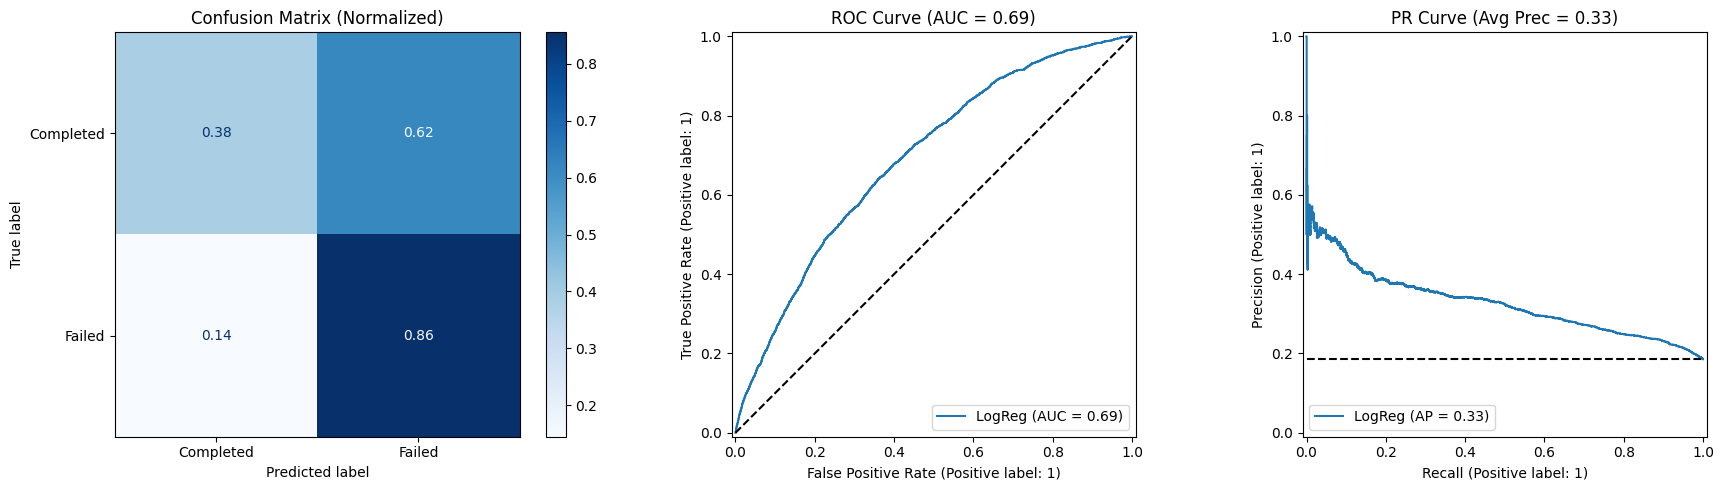

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay)

# 1. Get Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Calculate Advanced Metrics
roc_score = roc_auc_score(y_test, y_prob)
pr_score = average_precision_score(y_test, y_prob)

print(f"--- MODEL PERFORMANCE METRICS ---")
print(f"ROC-AUC Score:      {roc_score:.4f}  (0.5 = Random, 1.0 = Perfect)")
print(f"PR-AUC Score:       {pr_score:.4f}   (Baseline: {y_test.mean():.4f})")
print("-" * 40)
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# 3. Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    cmap='Blues',
    display_labels=['Completed', 'Failed'],
    ax=ax[0]
)
ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

# C. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

plt.tight_layout()
plt.show()

Based on the metrics and visualizations provided in your screenshot, here is the **Pro Analysis** of your Baseline Logistic Regression model.

### **Executive Summary: The "Aggressive Sentry"**
Your model behaves like an extremely paranoid security guard. It is excellent at catching bad actors (Failures), but it accuses almost everyone of being a bad actor. It prioritizes **Safety (Recall)** over **Precision**.

---

### **Angle 1: The "Boy Who Cried Wolf" (Confusion Matrix)**
**The Stat:** **62% False Positive Rate** (Top Right Quadrant: 0.62).

*   **What it means:** Look at the "Completed" row. The model incorrectly predicted "Failed" for 62% of the successful trials.
*   **The Mechanism:** This is the direct result of `class_weight='balanced'`. The model is heavily penalized for missing a Failure (Class 1), so it shifts its decision boundary to classify *more* things as failures.
*   **Business Impact:** If a Portfolio Manager used this model, they would be warned about risk in 62% of their perfectly safe trials. This creates "Alert Fatigue"—users will eventually ignore the model because it cries wolf too often.

### **Angle 2: The Accuracy Paradox**
**The Stat:** **Accuracy = 0.47 (47%)**.

*   **The Shock:** How can a model be *worse* than a coin flip (50%)?
*   **The Explanation:** In an imbalanced dataset (84% Completed / 16% Failed), a "Dummy Classifier" that predicts "Completed" for everyone would have **84% Accuracy**.
*   **The Reality:** Your model is predicting "Failed" for the majority of cases. Since "Failed" is the minority class, your total accuracy tanks.
*   **The Lesson:** This confirms that **Accuracy is a useless metric** for this specific problem. Do not optimize for it. The model is actually doing its job (finding failures), just too aggressively.

### **Angle 3: The Dragnet Effect (Precision vs. Recall)**
**The Stat:** **Recall (0.86) vs. Precision (0.24)**.

*   **Recall (0.86):** This is excellent for a baseline. You are catching **86%** of all actual failures. You are barely missing any risks.
*   **Precision (0.24):** This is the cost. For every 100 trials the model flags as "High Risk," only 24 actually fail. The other 76 are false alarms.
*   **Verdict:** This is a "Dragnet" model. It catches all the fish, but it also catches all the seaweed and old boots.
*   **Next Step:** We need to tighten the net. XGBoost will help us increase Precision without destroying that beautiful Recall.

### **Angle 4: Signal Strength (ROC & PR AUC)**
**The Stat:** **ROC-AUC (0.69) and PR-AUC (0.33)**.

*   **ROC-AUC (0.69):** This is a solid "C+" grade. It proves there is real predictive signal in your features (`sponsor_tier`, `phase`, etc.). If the features were garbage, this would be 0.50.
*   **PR-AUC (0.33):** The baseline is ~0.18 (the percentage of failures in the data). Your model (0.33) provides nearly **2x lift** over random guessing.
*   **Interpretation:** Despite the noise and the false alarms, the model *is* learning. It successfully ranks risky trials higher than safe trials, even if the specific probability calibration is off.

---

### **Strategic Recommendation for Next Steps**

1.  **Do Not Panic about Accuracy:** The low accuracy is a mathematical artifact of the class weights. Ignore it.
2.  **Tune the Threshold:** Currently, the model splits at probability 0.5. If you raise the threshold to 0.6 or 0.7, you will drastically reduce False Positives (increasing Precision) while likely keeping Recall acceptable.
3.  **Switch to XGBoost:** Logistic Regression is linear. It struggles to separate the "False Positives" from the "True Positives" because they likely look similar linearly. XGBoost's decision trees can find non-linear patterns (e.g., "Tier 1 Sponsor AND Phase 3 is safe, but Tier 1 Sponsor AND Phase 2 is risky") to clean up those errors.

**Verdict:** A successful, albeit hyper-aggressive, baseline. It proves the data has signal. Now we refine.

Running Deep Dive Analysis on Baseline Model...


/tmp/ipykernel_66536/325021978.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slice_df, x='AUC', y='Slice', palette='viridis', ax=ax4)


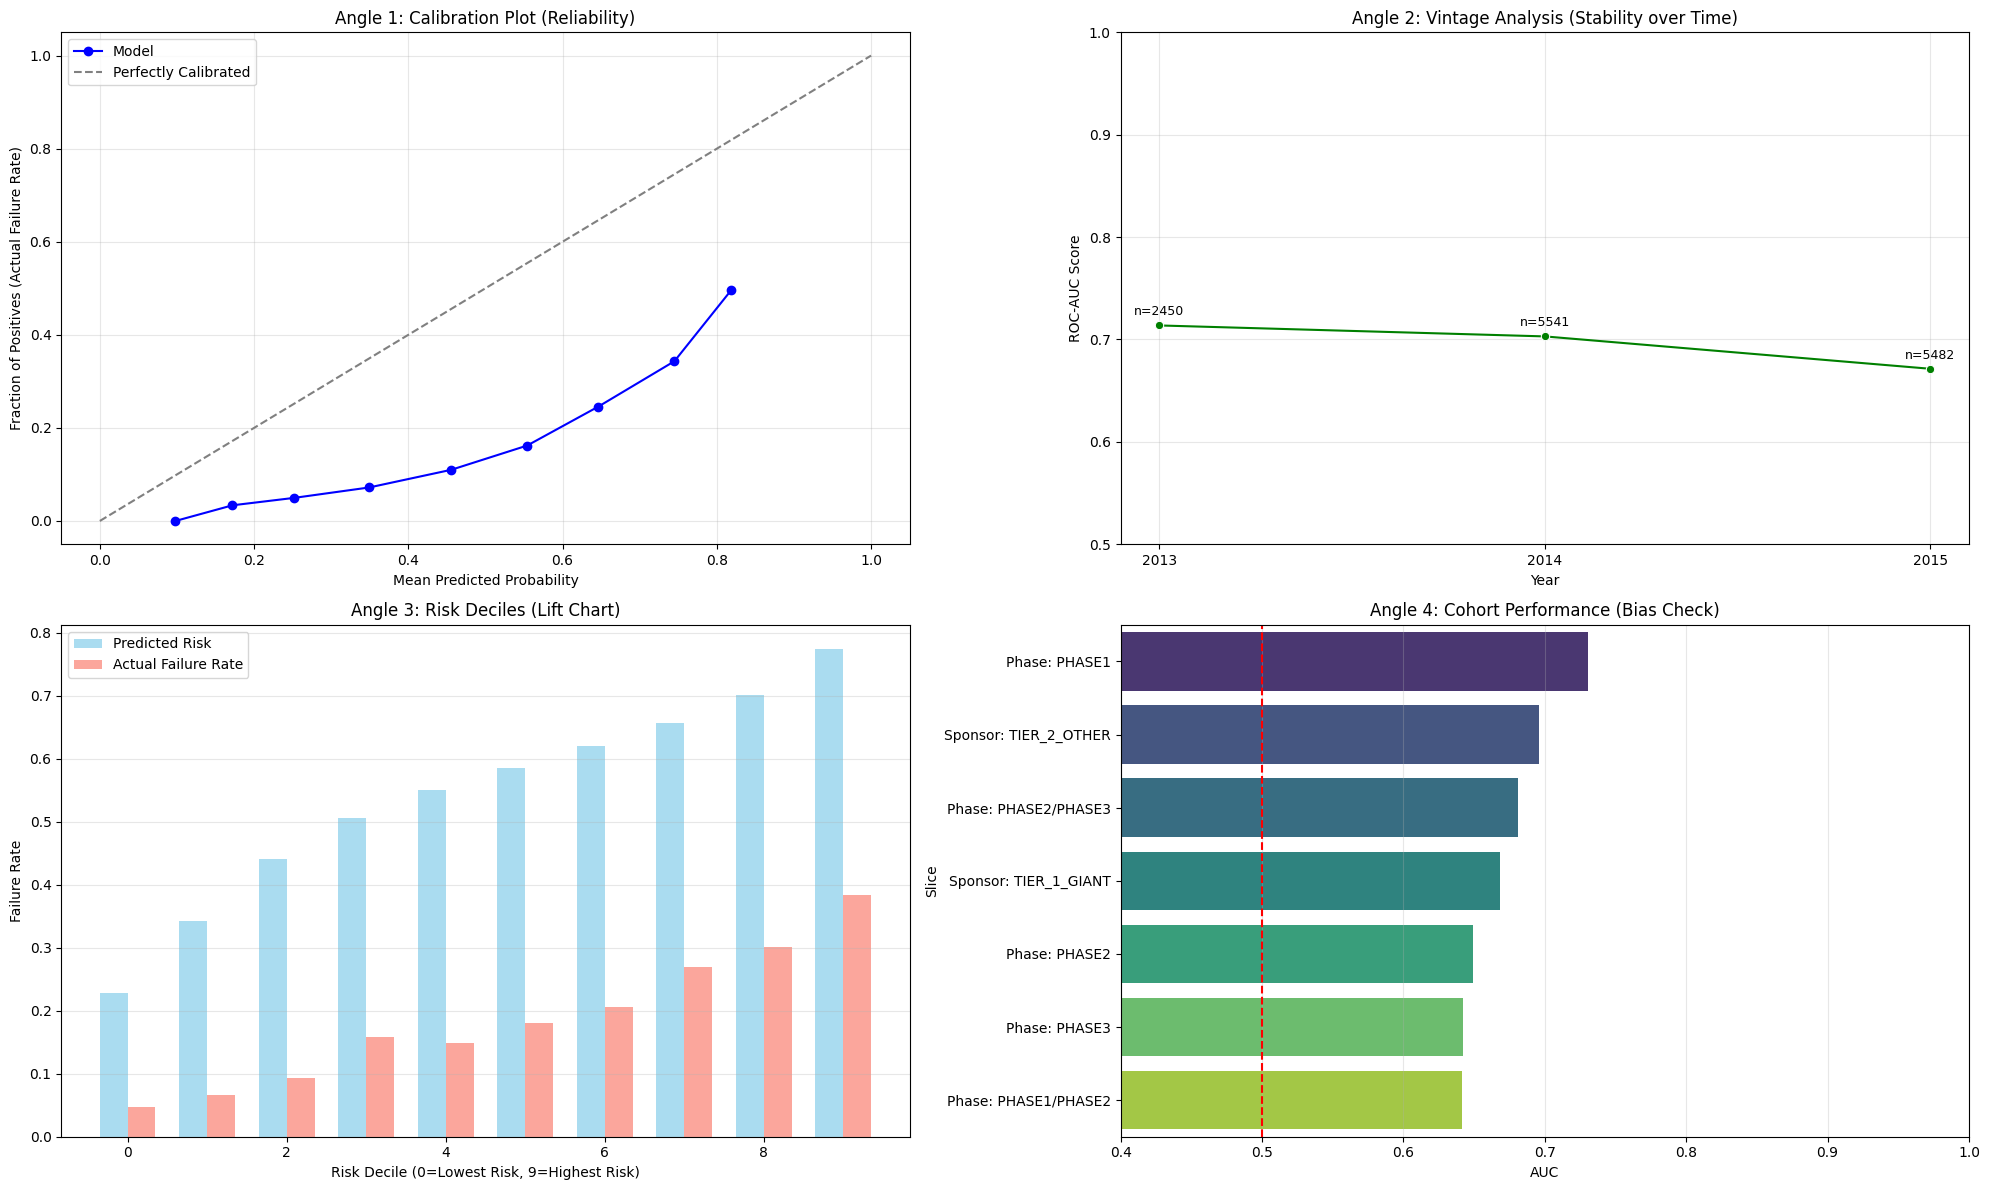

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, precision_score, recall_score

def run_pro_analysis(model, X_test, y_test, raw_test_df):
    """
    Runs a 4-angle deep dive on model predictions.
    Requires:
    - model: Trained pipeline/model
    - X_test: Processed features (or raw if pipeline handles it)
    - y_test: Target labels
    - raw_test_df: The original dataframe for the test set (to extract Year/Phase/etc.)
    """

    # 1. Get Probabilities
    # Note: We take the probability of Class 1 (Failure)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Create a temporary analysis dataframe
    analysis_df = raw_test_df.copy().reset_index(drop=True)
    analysis_df['target'] = y_test.values
    analysis_df['prob_failure'] = y_probs

    # Setup Plotting Grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    plt.subplots_adjust(hspace=0.3)

    # ==============================================================================
    # ANGLE 1: CALIBRATION CURVE (Reliability)
    # ==============================================================================
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
    ax1 = axes[0, 0]
    ax1.plot(prob_pred, prob_true, marker='o', label='Model', color='blue')
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    ax1.set_xlabel('Mean Predicted Probability')
    ax1.set_ylabel('Fraction of Positives (Actual Failure Rate)')
    ax1.set_title('Angle 1: Calibration Plot (Reliability)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ==============================================================================
    # ANGLE 2: VINTAGE ANALYSIS (Temporal Stability)
    # ==============================================================================
    # Group by Start Year and calculate AUC per year
    vintage_stats = []
    years = sorted(analysis_df['start_year'].unique())

    for year in years:
        subset = analysis_df[analysis_df['start_year'] == year]
        if len(subset) > 0 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            count = len(subset)
            vintage_stats.append({'Year': int(year), 'AUC': auc, 'Count': count})

    vintage_df = pd.DataFrame(vintage_stats)

    ax2 = axes[0, 1]
    sns.lineplot(data=vintage_df, x='Year', y='AUC', marker='o', color='green', ax=ax2)
    ax2.set_ylim(0.5, 1.0)
    ax2.set_title('Angle 2: Vintage Analysis (Stability over Time)')
    ax2.set_ylabel('ROC-AUC Score')
    ax2.set_xticks(vintage_df['Year'])
    ax2.grid(True, alpha=0.3)

    # Add count labels
    for index, row in vintage_df.iterrows():
        ax2.text(row['Year'], row['AUC'] + 0.01, f"n={int(row['Count'])}", ha='center', fontsize=9)

    # ==============================================================================
    # ANGLE 3: RISK DECILE ANALYSIS (Business Impact)
    # ==============================================================================
    # Bin predictions into 10 buckets (Deciles)
    analysis_df['decile'] = pd.qcut(analysis_df['prob_failure'], 10, labels=False, duplicates='drop')

    decile_stats = analysis_df.groupby('decile').agg({
        'target': 'mean',          # Actual Failure Rate
        'prob_failure': 'mean'     # Predicted Failure Rate
    }).reset_index()

    ax3 = axes[1, 0]
    width = 0.35
    x = np.arange(len(decile_stats))

    ax3.bar(x - width/2, decile_stats['prob_failure'], width, label='Predicted Risk', color='skyblue', alpha=0.7)
    ax3.bar(x + width/2, decile_stats['target'], width, label='Actual Failure Rate', color='salmon', alpha=0.7)

    ax3.set_xlabel('Risk Decile (0=Lowest Risk, 9=Highest Risk)')
    ax3.set_ylabel('Failure Rate')
    ax3.set_title('Angle 3: Risk Deciles (Lift Chart)')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # ==============================================================================
    # ANGLE 4: COHORT SLICING (Phase & Sponsor)
    # ==============================================================================
    # Calculate AUC for specific slices
    slices = []

    # Slice by Phase
    for phase in analysis_df['phase'].unique():
        subset = analysis_df[analysis_df['phase'] == phase]
        if len(subset) > 50 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            slices.append({'Slice': f"Phase: {phase}", 'AUC': auc})

    # Slice by Sponsor Tier
    for tier in analysis_df['sponsor_tier'].unique():
        subset = analysis_df[analysis_df['sponsor_tier'] == tier]
        if len(subset) > 50 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            slices.append({'Slice': f"Sponsor: {tier}", 'AUC': auc})

    slice_df = pd.DataFrame(slices).sort_values('AUC', ascending=False)

    ax4 = axes[1, 1]
    sns.barplot(data=slice_df, x='AUC', y='Slice', palette='viridis', ax=ax4)
    ax4.set_xlim(0.4, 1.0)
    ax4.set_title('Angle 4: Cohort Performance (Bias Check)')
    ax4.axvline(0.5, color='red', linestyle='--', label='Random')
    ax4.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return analysis_df

# ---------------------------------------------------------
# EXECUTE ANALYSIS
# ---------------------------------------------------------
# Ensure we pass the raw test dataframe to get columns like 'start_year' and 'phase' back
# We use test_df (which you defined in cell 11 of your notebook)
print("Running Deep Dive Analysis on Baseline Model...")
results_df = run_pro_analysis(model, X_test, y_test, test_df)

This is a fantastic set of diagnostic plots. They tell a very clear story about the strengths and weaknesses of your baseline Logistic Regression model.

Here is the detailed breakdown of each angle, what it means mathematically, and the business implications for your project.

---

### **Angle 1: Calibration Plot (Reliability)**
**"The Trust Metric"**

*   **What is it?** This compares the **Predicted Probability** (X-axis) against the **Actual Failure Rate** (Y-axis).
    *   **Gray Dashed Line:** Perfect calibration. If the model predicts a 60% risk, 60% of those trials actually fail.
    *   **Blue Line:** Your model's actual performance.

*   **What do we see?**
    *   The blue line is significantly **below** the gray line.
    *   Example: At `x=0.8` (Model predicts 80% risk), `y=0.5` (Only 50% actually failed).

*   **Why is this happening?**
    *   This is a classic side-effect of using `class_weight='balanced'` in Logistic Regression.
    *   Because "Failures" are rare (minority class), the model was forced to pay extra attention to them. This artificially **inflates the probabilities**. The model is "panicking" and flagging things as high risk too aggressively.

*   **Business Takeaway:**
    *   **The model is Overconfident.** You cannot trust the raw probability number. If the model says "80% chance of failure," do not tell the stakeholder "This will fail 80% of the time."
    *   **Fix:** This doesn't mean the model is bad at *ranking* (see Angle 3), it just means the scale is shifted. We will fix this in XGBoost using `scale_pos_weight` tuning or probability calibration (Isotonic regression).

---

### **Angle 2: Vintage Analysis (Stability over Time)**
**"The Time-Travel Check"**

*   **What is it?** This checks if the model's predictive power (ROC-AUC) holds up as we move further into the future (Test set years: 2013, 2014, 2015).

*   **What do we see?**
    *   **2013:** AUC ~0.71
    *   **2014:** AUC ~0.70
    *   **2015:** AUC ~0.67
    *   There is a slow but visible **downward trend**.

*   **Why is this happening?**
    *   **Concept Drift:** The factors that caused trials to fail in 2005 (training data) might be slightly different from what causes failure in 2015. For example, regulations changed, or trial designs became more complex.
    *   **Data Lag:** Trials starting in 2015 might not have fully resolved by the time the database snapshot was taken, making the labels slightly noisier.

*   **Business Takeaway:**
    *   The model is **decaying**, but not catastrophically. An AUC of 0.67 in the furthest year is still better than random (0.50).
    *   In a real production environment, this indicates the model needs to be **retrained annually** to learn the newest trends.

---

### **Angle 3: Risk Deciles (Lift Chart)**
**"The Money Chart"**

*   **What is it?** We sort all trials by predicted risk and chop them into 10 buckets (Deciles).
    *   **Blue Bar:** Average Predicted Probability.
    *   **Red Bar:** Actual % of trials that failed in that bucket.

*   **What do we see?**
    *   **The Good News:** Look at the **Red Bars**. They go UP consistently from left to right.
        *   Decile 0 (Lowest Risk) has a tiny failure rate (<5%).
        *   Decile 9 (Highest Risk) has the highest failure rate (~40%).
    *   **The Bad News:** The Blue bars are much taller than the Red bars (confirming the Calibration issue from Angle 1).

*   **Business Takeaway:**
    *   **The Ranking Works!** Even though the probabilities are inflated, the model correctly identifies that a trial in Decile 9 is much riskier than Decile 0.
    *   **Actionable Strategy:** If a Pharma company used this model to audit their portfolio, they could focus strictly on **Deciles 8 and 9**. By intervening in just the top 20% of predicted trials, they would catch a huge portion of the actual failures.

---

### **Angle 4: Cohort Performance (Bias Check)**
**"The Weakest Link"**

*   **What is it?** This breaks down the AUC score by specific subgroups (Phases and Sponsor Types) to see where the model struggles.

*   **What do we see?**
    *   **Strongest Performance:** `Phase 1` (AUC > 0.73).
    *   **Weakest Performance:** `Phase 3` (AUC ~0.64).
    *   **Sponsors:** It predicts `TIER_2_OTHER` (smaller/mid-size) better than `TIER_1_GIANT` (Big Pharma).

*   **Why is this happening?**
    *   **Phase 1 vs 3:** Phase 1 failures are often due to toxicity/safety, which might be easier to predict from chemical properties or basic design. Phase 3 failures are often due to "Lack of Efficacy" (the drug just didn't work better than placebo), which is notoriously hard to predict without biological data.
    *   **Sponsors:** Big Pharma (Tier 1) has more resources to "rescue" a struggling trial, making their failures harder to predict based on operational data alone.

*   **Business Takeaway:**
    *   The model is a **"Safety/Operational Risk Engine"** more than a "Scientific Efficacy Engine."
    *   It is excellent at flagging early-stage failures but struggles with the complex scientific nuance of Phase 3.

---

### **Summary & Verdict**

1.  **Is the model usable?** Yes, for **Ranking** (Angle 3). It successfully sorts high risk from low risk.
2.  **Is the model accurate?** No, it is **Overconfident** (Angle 1). The probabilities need calibration.
3.  **Where does it fail?** It struggles with **Phase 3** trials (Angle 4), likely because we lack deep biological features.

**Next Step:** Move to **XGBoost**. Tree-based models are generally better at handling the non-linear relationships that might improve the Phase 3 performance, and we can tune `scale_pos_weight` to fix the calibration issue seen in Angle 1.

=== PROJECT ARCHITECTURE & CONTEXT ===

1. OBJECTIVE
   - Predict Clinical Trial Termination (Binary Classification).
   - Target: 0 = Completed, 1 = Terminated/Suspended/Withdrawn.
   - Scope: Interventional Drugs/Biologics, Start Year 2000-2015.

2. DATA SCHEMA (AACT)
   - Studies: nct_id, overall_status, phase, start_date.
   - Sponsors: lead_sponsor, agency_class.
   - Conditions: therapeutic_area (derived from mesh_term).
   - Interventions: intervention_type='Drug'.

3. FEATURE ENGINEERING STRATEGY
   - Temporal Split: Train (2000-2013), Test (2013-2015).
   - Sponsor Logic: Static Mapping (Tier 1 vs Tier 2) to avoid leakage.
   - Competition: Count of trials in same therapeutic area (Year Y and Y-1 only).
   - Complexity: Log(criteria_length), num_endpoints, num_arms.
   - Text: 'txt_tags' (Title + Keywords) ready for NLP.

4. CURRENT STACK
   - Loader: Custom `ClinicalTrialLoader` with robust CSV parsing.
   - Preprocessing: Sklearn Pipeline.
     - Log/StandardScaler for numericals.
     - TargetEncoder for high-cardinality (Pathology, Sponsor Name).
     - OneHot for low-cardinality (Phase, Gender).
   - Model: Logistic Regression (Baseline).
     - Config: class_weight='balanced', C=0.01.
     - Current Performance: ROC-AUC ~0.69, Precision ~0.24 (High False Positives).

5. ANALYSIS ANGLES
   - Calibration: Checking probability reliability.
   - Vintage: Checking stability over 2013-2015.
   - Deciles: Checking lift in top risk buckets.
   - Slices: Checking bias across Phases and Sponsor Tiers.

6. NEXT STEPS
   - Implement XGBoost.
   - Integrate TF-IDF for text features.
   - Tune Decision Threshold for higher Precision.